### Imports

In [26]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM, GlobalAveragePooling1D, Dense, Dropout, Masking, Input, BatchNormalization, Flatten
from keras.models import Sequential
from keras.activations import sigmoid, relu
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras import mixed_precision
#from tensorflow.distribute import MirroredStrategy
#from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

### Mixed Precision

In [27]:
#mixed_precision.experimental.Policy('mixed_float16')

### Data Set Location

In [28]:
datapath = "./Input/"
types = ["BodyWeightSquats", "Lunges", "PushUps", "ThrowDiscus"] # only classifying between these
extension = "*.csv"

### Generate DataFrame

In [29]:
main_df = pd.DataFrame()

for count, cur in enumerate(types):
    current_glob = glob.glob(datapath+cur+"/"+extension)
    df = pd.DataFrame()
    li = []

    for filename in current_glob:
        df = pd.read_csv(filename, index_col=None, header=0)
        p = re.compile("v_(.*)\.csv")
        filename = p.findall(filename)[0]
        df.insert(0, 'example', filename)
        df.insert(0, 'exercise', cur)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    if count == 0:
        main_df = pd.DataFrame(columns=frame.columns, data=frame)
    else:
        main_df = pd.concat([main_df, frame])


print(main_df.head(100000))

               exercise                   example  frame    NOSE.x    NOSE.y  \
0      BodyWeightSquats  BodyWeightSquats_g01_c01      0  0.468669  0.069361   
1      BodyWeightSquats  BodyWeightSquats_g01_c01      1  0.468662  0.069879   
2      BodyWeightSquats  BodyWeightSquats_g01_c01      2  0.468611  0.070022   
3      BodyWeightSquats  BodyWeightSquats_g01_c01      3  0.468610  0.069943   
4      BodyWeightSquats  BodyWeightSquats_g01_c01      4  0.468484  0.069916   
...                 ...                       ...    ...       ...       ...   
11883       ThrowDiscus       ThrowDiscus_g25_c05     91       NaN       NaN   
11884       ThrowDiscus       ThrowDiscus_g25_c05     92       NaN       NaN   
11885       ThrowDiscus       ThrowDiscus_g25_c05     93       NaN       NaN   
11886       ThrowDiscus       ThrowDiscus_g25_c05     94       NaN       NaN   
11887       ThrowDiscus       ThrowDiscus_g25_c05     95       NaN       NaN   

         NOSE.z    NOSE.v  LEFT_EYE_INN

### Determine Maximum Number of Frames

271


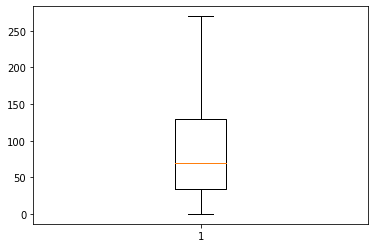

In [30]:
max_frames = main_df.frame.max() + 1
print(max_frames)
plt.boxplot(main_df.frame)
plt.show()

### Calculate $\hat{y}$

In [31]:
print(len(pd.unique(main_df.example)))
#print(main_df.head())
yhat = main_df.groupby(by="example").exercise.max()

yhat = pd.get_dummies(yhat)
print(yhat)

463
                          BodyWeightSquats  Lunges  PushUps  ThrowDiscus
example                                                                 
BodyWeightSquats_g01_c01                 1       0        0            0
BodyWeightSquats_g01_c02                 1       0        0            0
BodyWeightSquats_g01_c03                 1       0        0            0
BodyWeightSquats_g01_c04                 1       0        0            0
BodyWeightSquats_g02_c01                 1       0        0            0
...                                    ...     ...      ...          ...
ThrowDiscus_g25_c01                      0       0        0            1
ThrowDiscus_g25_c02                      0       0        0            1
ThrowDiscus_g25_c03                      0       0        0            1
ThrowDiscus_g25_c04                      0       0        0            1
ThrowDiscus_g25_c05                      0       0        0            1

[463 rows x 4 columns]


### Apply Padding to Data Set

In [32]:
video_frames = []

NUM_FEATURES = 132

for video in main_df.groupby(by="example"):
    current = video[1]
    current = current.drop(columns=["exercise","frame","example"])
    current = current.to_numpy()
    #print(current.shape)
    #print(type(current))
    np.nan_to_num(current, copy=False, nan=-2.)
    padded = np.ones((max_frames, NUM_FEATURES))
    padded *= -2. # Number not between -1 and 1
    padded[0:current.shape[0],:] = current
    video_frames.append(padded)

### Generate x

In [33]:
x = np.stack(video_frames, axis=0)
print(x.shape)
print(yhat.shape)
#214 => 341 is the video count
#267 => 271 is max length of a video
#132 is the number of features per frame

(463, 271, 132)
(463, 4)


In [34]:
x[0]
#What are the features, keypoint, x, y ,z so nose, shoulder, hand, elbow, etc.
#These are points in 3d space?yes, localized
#and you have params set up for all the different parts of the body to track?
#How much data do you have? Gonna need a fuckin lot of it to train this, yeah , i was thinking we need more data
#Your network is tiny as well for this. For our very simple lstm it's double the size of yours and also deeper

#some of these numbers are the same, you can one hot encode them

array([[ 0.46866941,  0.06936088, -0.10580542, ...,  0.8293696 ,
         0.18381335,  0.28686142],
       [ 0.46866211,  0.06987888, -0.10384705, ...,  0.83663428,
         0.28486028,  0.31443235],
       [ 0.46861085,  0.07002214, -0.09624683, ...,  0.85010797,
         0.24064758,  0.34029156],
       ...,
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ]])

### Splitting the Data Set

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, yhat, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(370, 271, 132)
(93, 271, 132)


### Compiling the Model
## TODO: Fix Accuracy

In [10]:
#Optimizer
#opt = Adam(learning_rate=0.00001)#clipnorm=1, clipvalue=0.5
opt = RMSprop(learning_rate=0.0001)#, clipvalue=0.5)

model = Sequential()
#model.add(Flatten())
#model.add(Input(x.shape)) #put the network shapes
model.add(Masking(mask_value=-2., input_shape=((x.shape[1],x.shape[2]))))
model.add(LSTM(64, recurrent_dropout=0.3, dtype='float32', return_sequences=True))#.3
model.add(LSTM(64, recurrent_dropout=0.3, dtype='float32'))
#model.add(Dense(32, activation='tanh', dtype='float32'))
#model.add(Dropout(0.2,dtype='float32'))
model.add(Dense(len(types), activation='softmax', dtype='float32'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_filepath='./checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(x_train, y_train)
model.summary()

12/12 [==============================] - 17s 1s/step - loss: 1.3727 - accuracy: 0.2486
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 271, 132)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 271, 64)           50432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 83,716
Trainable params: 83,716
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [21]:
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback])
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))
#model.fit(x, yhat, batch_size=32, epochs=10, validation_split=0.2, verbose=2)
model.summary()

Epoch 1/50
12/12 [==============================] - 8s 696ms/step - loss: 1.2847 - accuracy: 0.4838 - val_loss: 1.2507 - val_accuracy: 0.5591
Epoch 2/50
12/12 [==============================] - 8s 668ms/step - loss: 1.2066 - accuracy: 0.5703 - val_loss: 1.1761 - val_accuracy: 0.5376
Epoch 3/50
12/12 [==============================] - 8s 669ms/step - loss: 1.1218 - accuracy: 0.6108 - val_loss: 1.0922 - val_accuracy: 0.6022
Epoch 4/50
12/12 [==============================] - 8s 669ms/step - loss: 1.0414 - accuracy: 0.6595 - val_loss: 1.0308 - val_accuracy: 0.6774
Epoch 5/50
12/12 [==============================] - 8s 666ms/step - loss: 0.9668 - accuracy: 0.6865 - val_loss: 1.0308 - val_accuracy: 0.5806
Epoch 6/50
12/12 [==============================] - 8s 674ms/step - loss: 0.9169 - accuracy: 0.6892 - val_loss: 0.9216 - val_accuracy: 0.6667
Epoch 7/50
12/12 [==============================] - 8s 665ms/step - loss: 0.8618 - accuracy: 0.7216 - val_loss: 0.8765 - val_accuracy: 0.6452
Epoch 

### Save the Model
Saves the model to a h5 file to be used for predictions

In [11]:
#Load the best weights
model.load_weights(checkpoint_filepath)

In [26]:
model.load_weights(checkpoint_filepath)
model.save('poseNetworkLSTMwithDiscus2LSTM.h5')

### Make Predictions

In [36]:
y_pred = model.predict(x)
pred = np.argmax(y_pred, axis=1)
true = np.argmax(yhat.to_numpy(), axis=1)
pred_mapped = np.asarray(types)[pred]
true_mapped = np.asarray(types)[true]
diff = true - pred

#{'True':True}
#"Lunges", "BodyWeightSquats", "PushUps"


In [37]:
wrong = [i for i, e in enumerate(diff) if e != 0]
for index in wrong:
    print(true_mapped[index]+' was misclassified as '+pred_mapped[index])
    #print(true[index])

BodyWeightSquats was misclassified as Lunges
BodyWeightSquats was misclassified as Lunges
BodyWeightSquats was misclassified as ThrowDiscus
BodyWeightSquats was misclassified as Lunges
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
PushUps was misclassified as ThrowDiscus
ThrowDiscus was misclassified as BodyWeightSquats
ThrowDiscus was misclassified as BodyWeightSquats
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges


In [57]:
#only validation data
y_pred_test = model.predict(x_test)
pred_test = np.argmax(y_pred_test, axis=1)
true_test = np.argmax(y_test.to_numpy(), axis=1)
pred_test_mapped = np.asarray(types)[pred]
true_test_mapped = np.asarray(types)[true]
diff_test = true - pred

In [58]:
wrong_test = [i for i, e in enumerate(diff_test) if e != 0]
for index in wrong_test:
    print(true_test_mapped[index]+' was misclassified as '+pred_test_mapped[index])

BodyWeightSquats was misclassified as Lunges
BodyWeightSquats was misclassified as Lunges
BodyWeightSquats was misclassified as ThrowDiscus
BodyWeightSquats was misclassified as Lunges
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
Lunges was misclassified as ThrowDiscus
PushUps was misclassified as ThrowDiscus
ThrowDiscus was misclassified as BodyWeightSquats
ThrowDiscus was misclassified as BodyWeightSquats
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges
ThrowDiscus was misclassified as Lunges


Note the similarity in the above results, meaning that all of the incorrect classifications were during validation and that our model has overfit to the training data.

### Multi-GPU Training

In [12]:
# Create a MirroredStrategy.
strategy = MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    opt = RMSprop(learning_rate=0.000001)
    model = Sequential()
    model.add(Masking(mask_value=-2., input_shape=((x.shape[1],x.shape[2]))))
    model.add(LSTM(64,recurrent_dropout=0.3,dtype='float32'))
    model.add(Dense(len(types), activation='softmax', dtype='float32'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
    checkpoint_filepath='./checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 5 all-reduces with algorithm = nccl, num_pa

InternalError: 3 root error(s) found.
  (0) Internal:  Blas GEMM launch failed : a.shape=(32, 132), b.shape=(132, 64), m=32, n=64, k=132
	 [[node sequential_1/lstm_1/lstm_cell_1/MatMul_3 (defined at /lib/python3.6/threading.py:916) ]]
	 [[div_no_nan_1/ReadVariableOp_5/_468]]
  (1) Internal:  Blas GEMM launch failed : a.shape=(32, 132), b.shape=(132, 64), m=32, n=64, k=132
	 [[node sequential_1/lstm_1/lstm_cell_1/MatMul_3 (defined at /lib/python3.6/threading.py:916) ]]
  (2) Internal:  Blas GEMM launch failed : a.shape=(32, 132), b.shape=(132, 64), m=32, n=64, k=132
	 [[node sequential_1/lstm_1/lstm_cell_1/MatMul_3 (defined at /lib/python3.6/threading.py:916) ]]
	 [[replica_1/sequential_1/lstm_1/while/body/_789/gradients/lstm_cell_1/mul_2_grad/Shape_1/_342]]
0 successful operations.
2 derived errors ignored. [Op:__inference_train_function_15791]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
#accuracy is around 33%, basically guessing, also not learning, which is likely from the loss being nan
#batch normalization got rid of nan loss but did not learn

In [ ]:
#np.isnan(x_train)
np.isnan(x_test)
#assert not np.any(np.isnan(x_train))

In [ ]:
x_train

In [ ]:
x_test

In [ ]:
np.argwhere(np.isnan(x))

In [ ]:
x[9][18]

In [59]:
%%time
model.predict(x_test)

CPU times: user 927 ms, sys: 88.6 ms, total: 1.02 s
Wall time: 542 ms


array([[0.95475584, 0.02058202, 0.00210909, 0.02255307],
       [0.00249685, 0.00390107, 0.97757757, 0.01602448],
       [0.9551835 , 0.0243447 , 0.00203214, 0.01843958],
       [0.1308006 , 0.8544655 , 0.00337702, 0.01135686],
       [0.79070115, 0.18307923, 0.00413567, 0.02208393],
       [0.00266109, 0.00389436, 0.98442245, 0.00902213],
       [0.9366374 , 0.0393694 , 0.00267966, 0.02131348],
       [0.14671798, 0.78669286, 0.00342672, 0.06316249],
       [0.02471654, 0.93134886, 0.00434138, 0.03959317],
       [0.02965869, 0.94393957, 0.00418996, 0.02221179],
       [0.01583527, 0.01824623, 0.00181932, 0.9640992 ],
       [0.02795384, 0.01293084, 0.00682001, 0.95229536],
       [0.01723526, 0.9175413 , 0.00449474, 0.06072867],
       [0.9563133 , 0.02021888, 0.00194497, 0.02152287],
       [0.01320647, 0.01850308, 0.00230132, 0.9659891 ],
       [0.9539616 , 0.01793161, 0.00188776, 0.02621901],
       [0.01185818, 0.00863943, 0.9472953 , 0.03220703],
       [0.02886909, 0.7208152 ,

In [17]:
keras.__version__

NameError: name 'keras' is not defined

In [18]:
tensorflow.__version__

NameError: name 'tensorflow' is not defined

In [19]:
np.argmax(y_test.to_numpy(), axis=1)

array([3, 3, 2, 1, 0, 2, 3, 1, 2, 0, 0, 0, 0, 3, 3, 1, 1, 2, 2, 0, 3, 1,
       3, 3, 3, 1, 1, 0, 3, 0, 3, 1, 2, 0, 0, 1, 3, 2, 0, 2, 0, 1, 1, 0,
       0, 1, 3, 0, 3, 1, 1, 0, 1, 1, 3, 3, 0, 1, 3, 1, 2, 0, 3, 1, 0, 0,
       3, 3, 0, 3, 2, 1, 3, 1, 0, 2, 2, 0, 2, 3, 1, 2, 3, 3, 3, 2, 1, 3,
       0, 1, 3, 0, 1])

In [39]:
yhat.sum()

BodyWeightSquats    112
Lunges              127
PushUps             100
ThrowDiscus         124
dtype: int64

In [49]:
#Accuracy
print('BodyWeightSquats:',(112-4)/112)#7, 19
print('Lunges:',(127-7)/127)#4, 9
print('PushUps:',(100-1)/100)#0
print('ThrowDiscus:',(124-7)/124)#9

BodyWeightSquats: 0.9642857142857143
Lunges: 0.9448818897637795
PushUps: 0.99
ThrowDiscus: 0.9435483870967742


In [ ]:
#Precision TruePositives / (TruePositives + FalsePositives)
print('BodyWeightSquats:',(112-7)/112)
print('Lunges:',(127-4)/127)
print('PushUps:',(100-1)/100)
print('ThrowDiscus:',(124-7)/124)

In [ ]:
#Recall TruePositives / (TruePositives + FalseNegatives)
print('BodyWeightSquats:',(112-7)/112)
print('Lunges:',(127-4)/127)
print('PushUps:',(100-1)/100)
print('ThrowDiscus:',(124-7)/124)

In [41]:
acc = 100. * accuracy_score(true, pred)
print('Accuracy: {:.2f}%'.format(acc))

Accuracy: 95.90%


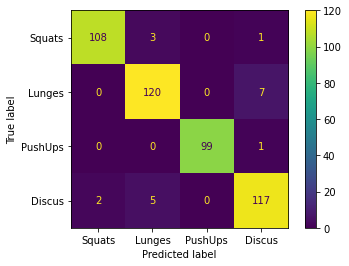

In [48]:
cm = confusion_matrix(true, pred)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Squats','Lunges','PushUps','Discus'])
#cmp.from_predictions(true, pred, xticks_rotation='vertical')
cmp.plot()
plt.show()

In [51]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(true, pred, x_tick_rotation=45, normalize=True, labels=types)

ModuleNotFoundError: No module named 'scikitplot'

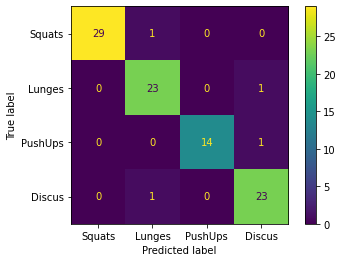

In [60]:
cm = confusion_matrix(true_test, pred_test)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Squats','Lunges','PushUps','Discus'])
#cmp.from_predictions(true, pred, xticks_rotation='vertical')
cmp.plot()
plt.show()

In [61]:
#Accuracy
print('BodyWeightSquats:',(30-1)/30)#7, 19
print('Lunges:',(24-1)/24)#4, 9
print('PushUps:',(14-1)/14)#0
print('ThrowDiscus:',(24-1)/24)#9

BodyWeightSquats: 0.9666666666666667
Lunges: 0.9583333333333334
PushUps: 0.9285714285714286
ThrowDiscus: 0.9583333333333334
